In [1]:
from body_matrix import load
from body_matrix import infer
from body_matrix import process

video, frame_counts, fps, sample_frame = load.video(
	"/Users/troydo42/Desktop/Raw_Vids/winmart_customer_01.mp4", 
	-90, 
	1
)

keypoints_model, keypoints_transform = load.keypoints_model("cpu")
selected_box, keypoints = infer.detect_main_target(
	sample_frame, "cpu", 0.8, keypoints_model, keypoints_transform
)

selected_kps = process.keypoints_filter(
	['nose','left_shoulder','right_shoulder'], 
	keypoints
)

segment_model, segment_transform = load.segment_model("cpu")
mask, mask_image, bool_mask = infer.segment_selected_target(
	sample_frame, "cpu", selected_box, 0.99, segment_model, segment_transform
)

segment_area = process.segmentation_area(
	sample_frame, 
	bool_mask
)


Found  4  person in the frame
Distances:  [27.205665588378906, 342.3337097167969, 480.35870456695557, 42.82427978515625]
Areas:  [774573.0474496037, 74028.65352323279, 23264.867656304967, 392740.9786874354]
FOCUSES:  [28471.01994006969, 216.24704614825876, 48.43228078333315, 9170.988529352157]
Select keypoint index 0
Found  3  person in the frame
[198.3819122314453, 558.0987548828125, 820.861083984375, 1874.1136474609375]
[221.1780242919922, 556.763427734375, 812.41064453125, 1866.862060546875]
[1.9949085712432861, 564.2308349609375, 133.7847137451172, 867.5205078125]
[221.1780242919922, 556.763427734375, 812.41064453125, 1866.862060546875]
[793.0635375976562, 634.2096557617188, 983.6800537109375, 925.6537475585938]
[221.1780242919922, 556.763427734375, 812.41064453125, 1866.862060546875]
[8.359626422216703, 668.9311258486275, 569.7289219949859]
8.359626422216703 0
tensor([ 556,  556,  556,  ..., 1871, 1871, 1871]) tensor([563, 564, 565,  ..., 607, 608, 609])


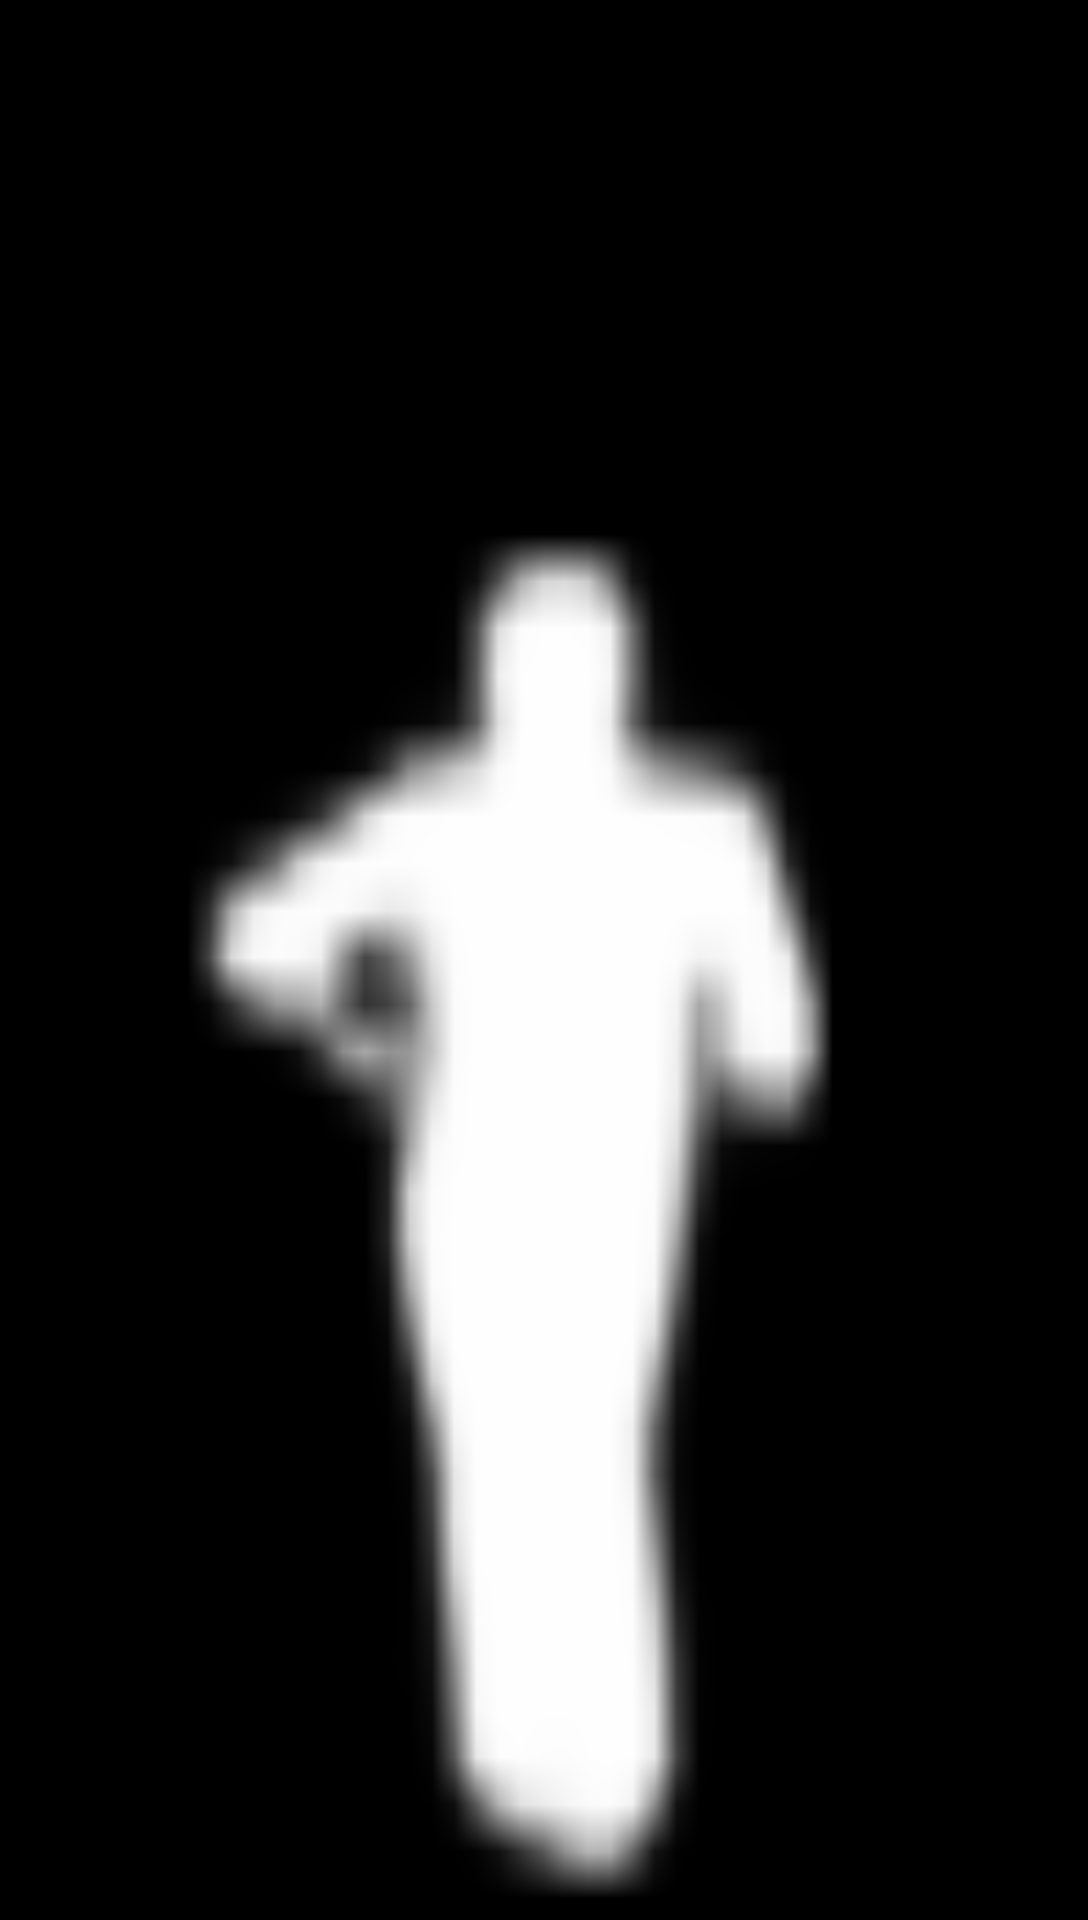

In [2]:
mask_image

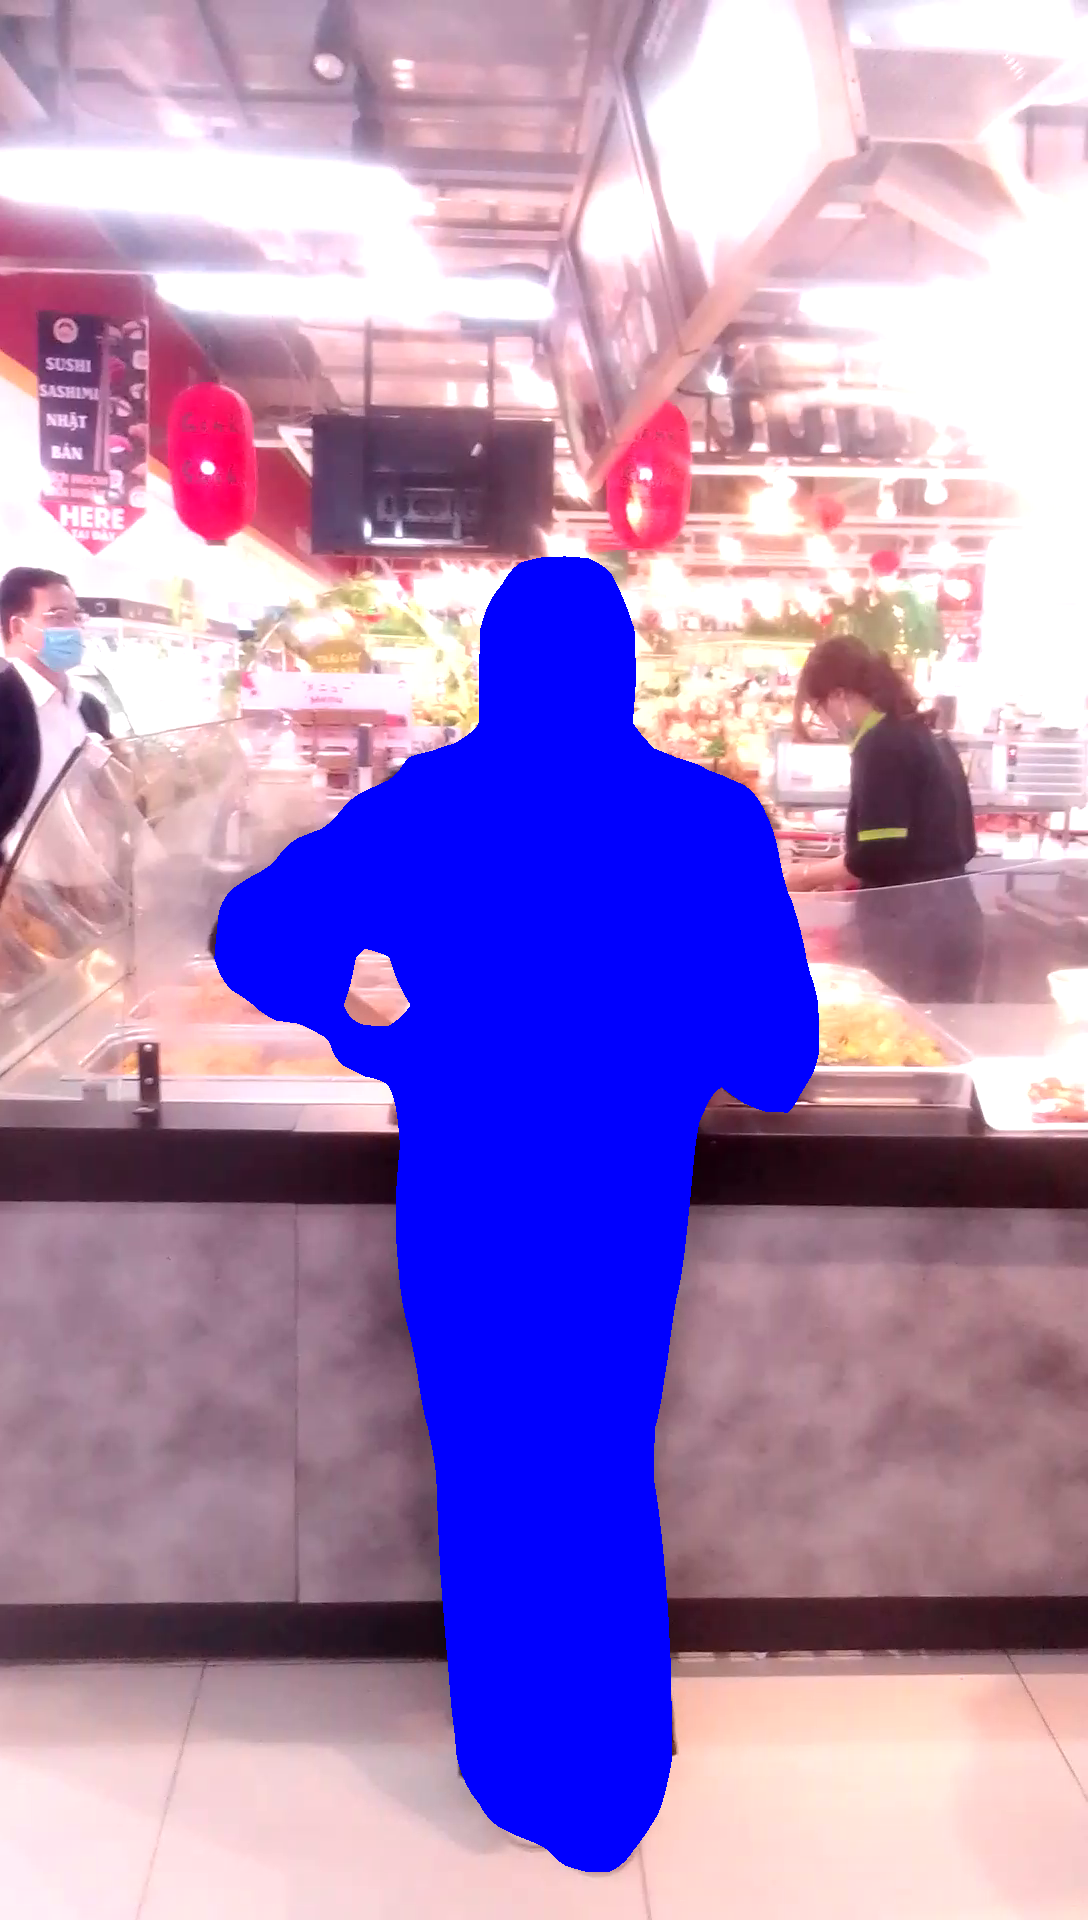

In [3]:
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import torch
from PIL import ImageColor

tensor_image = pil_to_tensor(sample_frame)
mask = torch.squeeze(bool_mask, 0)
img_to_draw = tensor_image.detach().clone()
color = ImageColor.getrgb('blue')
tensor_color = torch.tensor(color, dtype=torch.uint8)
img_to_draw[:, mask] = tensor_color[:, None]
colored = to_pil_image(img_to_draw)

x, y = torch.where(
    (img_to_draw[2] == 255)
    &(img_to_draw[0] == 0)
    &(img_to_draw[1] == 0)
)
colored

In [4]:
def check_if_contours(point, colored):
    [x, y] = point[0].item(), point[1].item()
    surrounding_pixels = [
        (x-1, y-1),(x, y-1),(x+1, y-1),
        (x-1, y), (x+1, y),
        (x-1, y+1), (x, y+1), (x+1, y+1)
    ]
    checked = 0
    
    for pixel in surrounding_pixels:
        color = colored.getpixel(pixel)
        if color != (0, 0, 255):
            checked = checked + 1
            
    return checked


result = check_if_contours(
    (x[0], y[0]), 
    colored
)

print(result)

0


In [5]:
contours = []
for x, y in zip(y, x):
    result = check_if_contours(
        (x, y), 
        colored
    )
    
    if result != 0:
        contours.append([x.item(), y.item()])


In [6]:
updated_contours = process.segmentation_contour(
    sample_frame, 
    bool_mask
)

In [7]:
print(len(contours))

4230


In [8]:
print(len(updated_contours))

4230


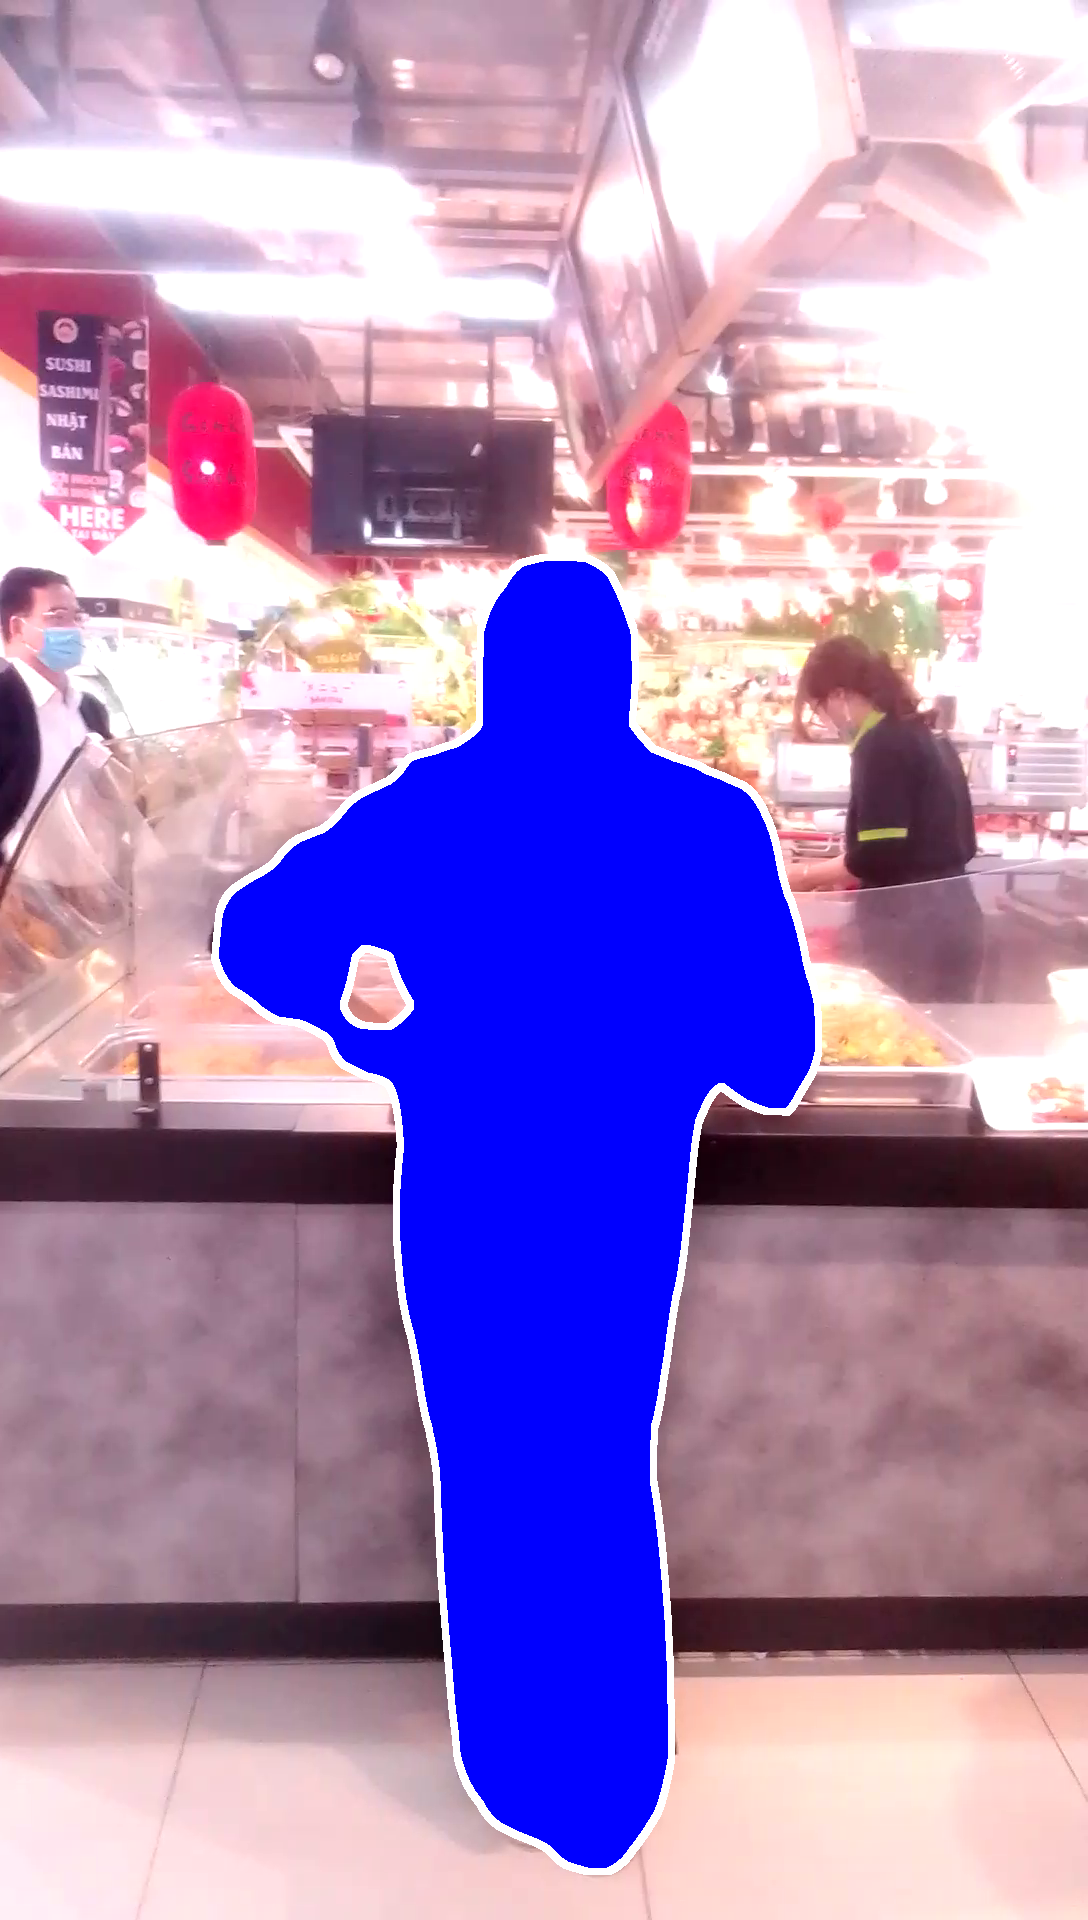

In [9]:
from body_matrix import draw

contoured = colored.copy()
for contour in contours:
    contoured = draw.circle_label(
        contoured, 
        3, 
        contour,
        background_color="#ffffff",
        label=" ", 
        label_font="/Users/troydo42/Desktop/Body_Matrixes/Roboto-Bold.ttf",
        label_color="#ffffff",   
    )
    
contoured

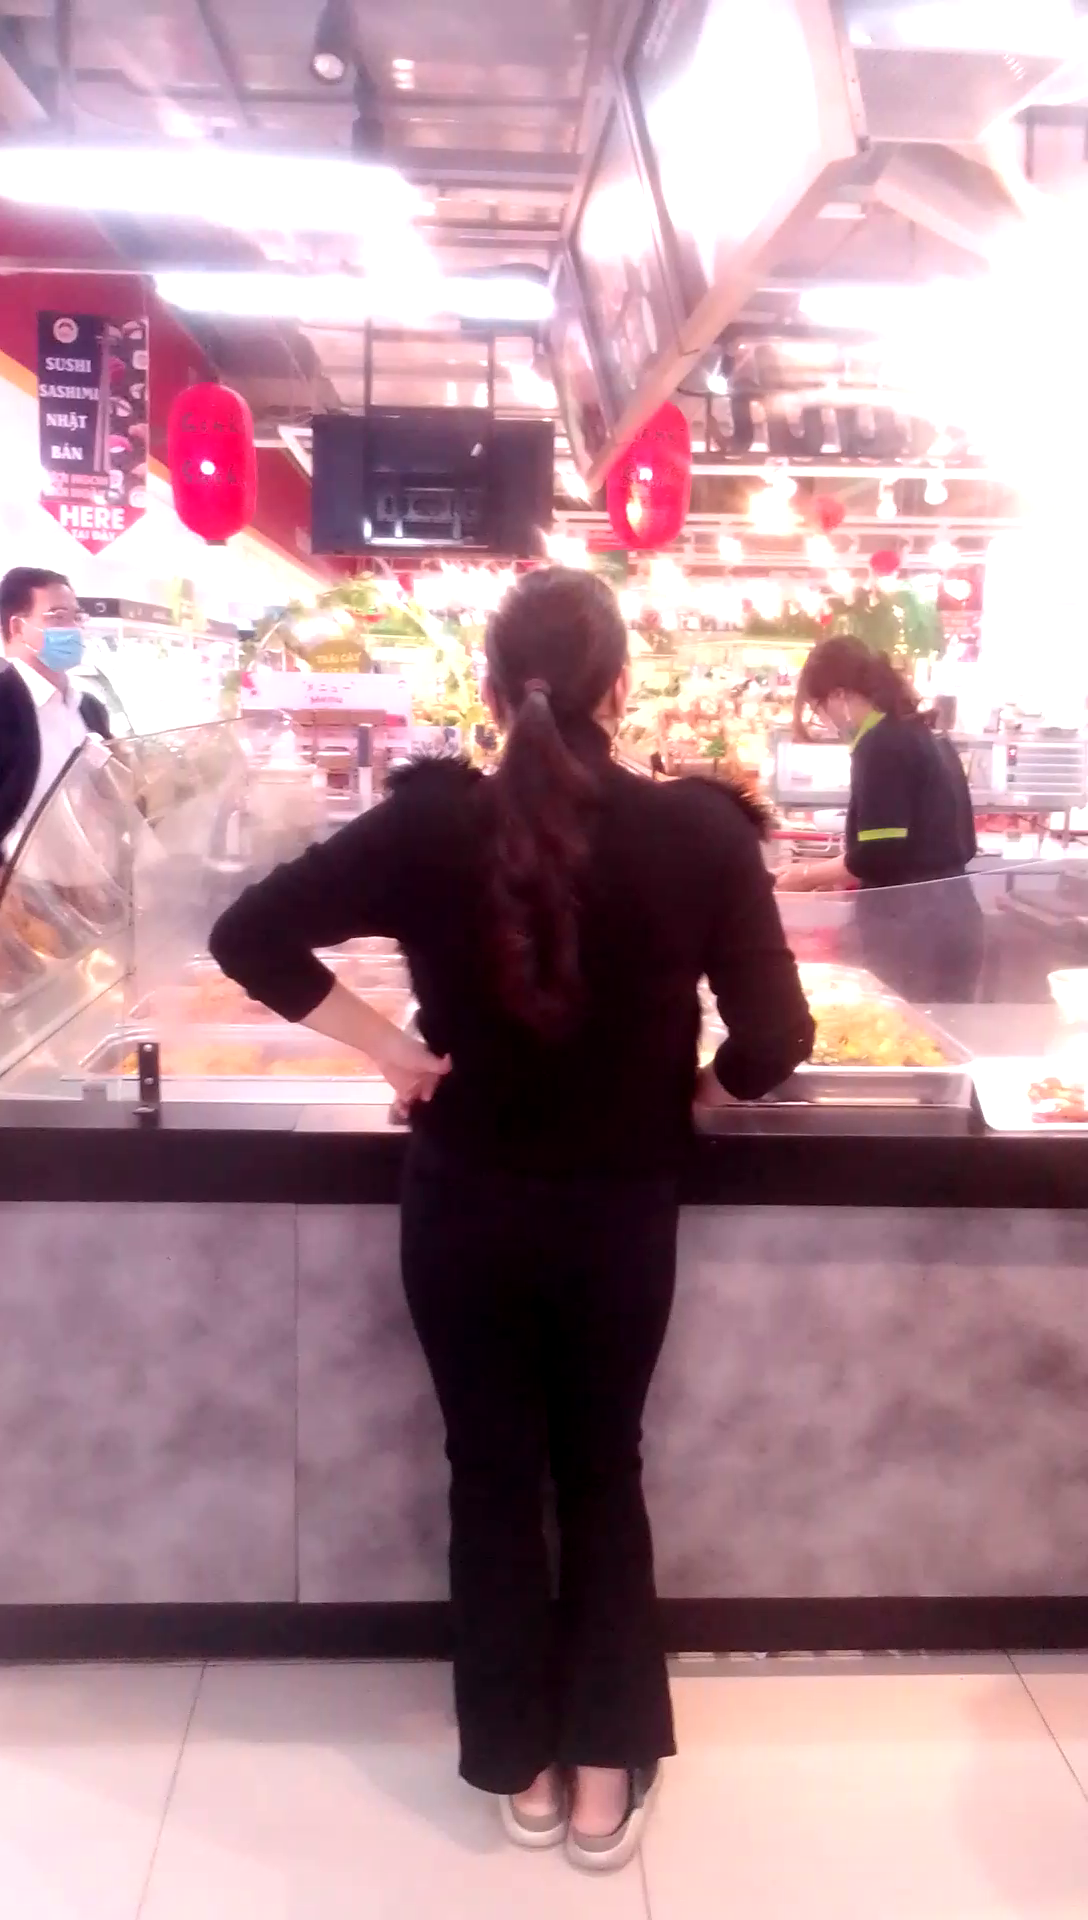

In [10]:
sample_frame

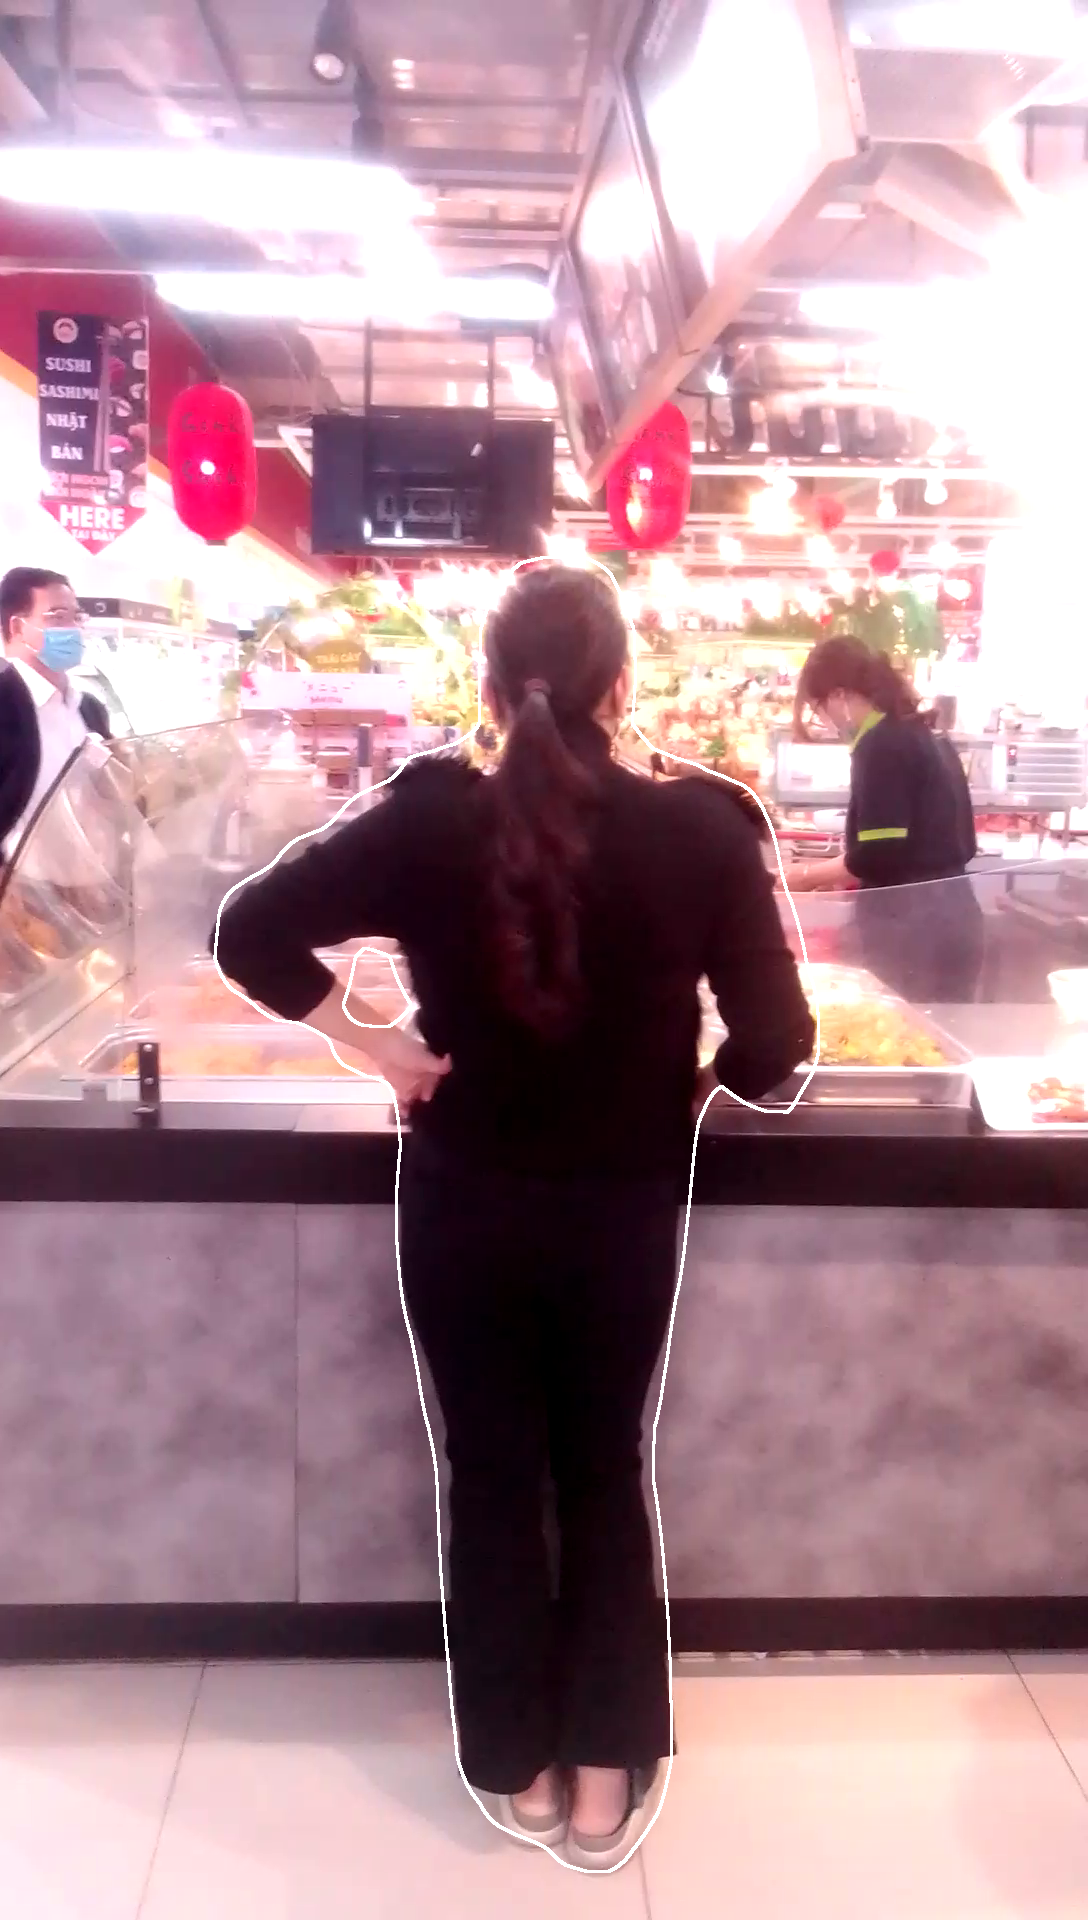

In [13]:
contoured_image = draw.segmentation_contour(
    contour_pixels = updated_contours, 
    contour_color="#ffffff",
    contour_size=1, 
    font="/Users/troydo42/Desktop/Body_Matrixes/Roboto-Bold.ttf",
    image=sample_frame, 
)
contoured_image